EE364b Convex Optimization II, S. Boyd

Written by Shuvomoy Das Gupta

-------------------

We want to solve the dual of the following problem using projected subgradient method:

$$
\begin{align}
& \text{minimize} \quad \frac{1}{2} x^T P x-q^T x\\
& \text{subject to} \quad x_i^2 \leq 1, \quad \forall i \in \{1,2,\ldots,n\}, 
\end{align}
$$
where, $P$ is a positive definite matrix.


In [1]:
# Data generation
n=50
A=randn(n,n)
P= A*A' # Enforcing Cholesky decomposition thus making P positive definite
eigsP=eigvals(P)
println("P is a positive definite matrix with max eigenvalue ", maximum(eigsP), "and minimumeigen value ", minimum(eigsP))
q=randn(n,1)


P is a positive definite matrix with max eigenvalue 180.67701100057442and minimumeigen value 0.0008002082051704444


50x1 Array{Float64,2}:
  0.594521 
 -0.135413 
 -0.32826  
 -0.642397 
  0.549878 
  0.294113 
  0.137859 
  0.125343 
  0.952007 
 -1.06564  
  0.301345 
 -1.19694  
 -1.00563  
  ⋮        
  1.04972  
 -0.474306 
 -0.921684 
 -0.459424 
  0.0968241
 -0.354891 
 -0.047402 
 -0.560208 
 -0.993366 
 -0.949164 
  0.933724 
 -0.624558 

Solving the problem using `Convex.jl`

In [2]:
# Solve the problem using Convex.jl
using Convex

using SCS

x̄=Variable(n)

obj=(0.5*quad_form(x̄, P))- dot(q,x̄)# quad_form(α, M):=αᵀMα in Convex
# For a detailed list of suppored operations see http://convexjl.readthedocs.org/en/latest/operations.html

constraints=[]# Declaring an empty vecotr of constraints first

# Let us add the constraints x[i]^2 in a loop...
for i in 1:n
  constraints += (x̄[i]^2 <= 1)
end

# Define the problem in
problem=
minimize( obj,
# subject to
constraints
)

# Let's solve it:
solve!(problem,SCSSolver())

# Let's look at the output

print("The status of the solution is ", problem.status)

xMinValue=x̄.value
fMinValue=problem.optval

println( "\nwith optimal objective value, f(x*)=", fMinValue,
"\noptimal solution is x*=", xMinValue)


The status of the solution is Optimal
with optimal objective value, f(x*)=-5.476793048069855
optimal solution is x*=[0.7417852497728099
 -0.09521404651622709
 0.25991749124880803
 -0.7245783465158094
 -0.10407312222761074
 -0.03655057165106471
 -1.000000599078033
 0.054580598226555935
 0.5509845375435042
 -0.6096240841708609
 0.23610333065942357
 0.7143144966817028
 0.0010516140605796238
 -0.1723858010070386
 0.10184183902400361
 0.6521919212272621
 -0.36368116356389985
 -0.4109030255324449
 0.18447980044716228
 -0.9433395898397728
 -0.34069797463620577
 -0.376577357545191
 0.5321753116029796
 1.0000012452283336
 0.6459198123342196
 0.1353267580770991
 0.010129709383055838
 -1.000001211829637
 0.5764349236275178
 -0.195458607260341
 0.23874845663883565
 -0.5446447773602164
 -0.9337331788417408
 -0.21965446724774432
 0.799402132385729
 0.4848483923945537
 -0.0355398953828563
 0.815967516934768
 0.7288597991558068
 0.04114299299655233
 -0.7797490596529874
 0.08684763492870734
 0.00760290

Applying the projected subgradient method for the primal problem

In [3]:
# Projected subgradient algorithm for primal problem
println("Projected subgradient algorithm for primal problem")

fPrmlSet=Float64[] # We are creating an empty array where we will store the primal objective values as we progress
push!(fPrmlSet,Inf) # Intial value of fPrimal is infinity

fPrmlBest=Float64[] # It is an array where the last element will give f_best^{(k)} so far for the primal objective
push!(fPrmlBest, Inf) # Intial best value of fPrimal is infinity
x=zeros(n,1) # intial starting point is taken to be zero

k=1 # k is the iteration counter, starting at 1

maxIter = 3000 # Maximum number of iterations

while(k < maxIter)

# Evaluate primal objective value
fKval=((0.5*x'*P*x)-q'*x)[1,1]# Julia treats the quantity as 1x1 matrix, so I am taking the [1,1] th element the number itself!

# Calculating the subgradient for the primal function which is essentially the gradient
gK=(P*x)-q

# Step size selcetion: Consider Polyak's step size
#αK=(fKval-fMinValue)/norm(gK)^2
#αK=0.001
αK=1/k

# Push the current value of f(x^(k)) in fSet
push!(fPrmlSet,fKval)

# Note how we are pushing the best f primal found so far in the last element of f
push!(fPrmlBest, min(fPrmlBest[end],fKval))

# Projected subgradient alg
x=x-αK*gK # Find the subgradient update
x=max(min(x,1),-1) # Project it on the set {x: ∀i xᵢ²<=1}
# min(x,1) compares each element of x with 1 and takes the minimum, and max(x,-1)  compares each element of x with -1 and takes the maximum
k=k+1
end # while

Projected subgradient algorithm for primal problem


Applying projected subgradient algorithm for dual problem

In [4]:
#Subgradient method for the dual problem
println("Subgradient method applied to the dual problem")

gDualSet=Float64[]

push!(gDualSet,-Inf)

gDualBest=Float64[]

push!(gDualBest,-Inf)

λ=ones(n)# Initial dual variable

k=1 # Iteration counter

while (k < maxIter)
# Calculating subgradient
# Calculating x^{(k)}
xStar=inv(P+diagm(vec(2*λ)))*q
#xStar=max(min(xStar,1),-1)
h=xStar.^2-1

# Calculating dual objective value
gKval=(-0.5*q'*xStar-sum(λ))[1,1]
push!(gDualSet,gKval)

push!(gDualBest, max(gKval,gDualBest[end]))
# Calculating primal objective value

# step size selection
sK=1/k

λ=max(0,λ+sK*h)

k=k+1
end


Subgradient method applied to the dual problem


Let's plot how both of the projected subgradient methods work

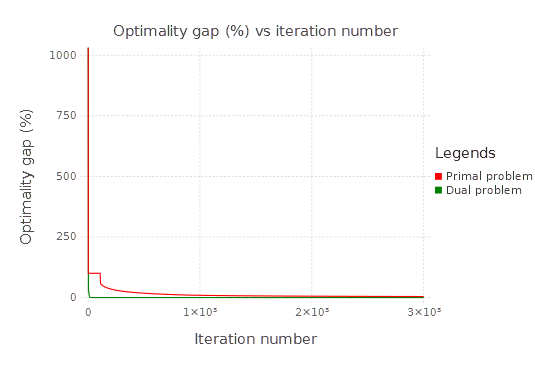

In [6]:
using Gadfly

curvePrimal=abs((fPrmlBest-fMinValue)/(fMinValue))*100
curveDual=abs((gDualBest-fMinValue)/fMinValue)*100

iters=1:maxIter
plot(
  layer(x=iters,y=curvePrimal,Geom.line, Theme(default_color=color("red"))),
        layer(x=iters, y=curveDual,Geom.line,Theme(default_color=color("green"))),
  Guide.manual_color_key("Legends", ["Primal problem","Dual problem"], 
[color("red"),color("green")]),
Guide.ylabel("Optimality gap (%)"), # label for y-axis
Guide.xlabel("Iteration number"),  # label for x-axis
Guide.title("Optimality gap (%) vs iteration number")
)